## LUNA malignancy diagosis classification
Malignancy Classification using 3D or 2D patches   

-**v5**   
   - Use darknet model (similar to the one used in Neurips workshop)   
   
-**v4** 
   - Also including images that DID NOT pass quality control (for correct inpainting)

-**v3** 
   - 3D versions   

-**v2** 
   - Adding random crop augmentation   
   - Using only images that passed inpainting QC   
   
-**v1** 2D version


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor
from torch import optim
from torch.utils.data import Sampler, WeightedRandomSampler
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torchsummary import summary
# import visdom
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import time
from copy import copy
from scipy.stats import mode
import os
import numpy as np
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
%matplotlib inline

In [2]:
import SimpleITK as sitk
import math
import scipy

In [3]:
from LSUV3D import LSUVinit3D, count_conv_fc_layers # initialization
from torch_lr_finder import LRFinder

/home/om18/anaconda3/envs/torch/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils_classifier.resnet import *
from utils_classifier.darknet import *
from utils_classifier.utils_classify_DIPs import *

In [6]:
path_source = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
path_lidc = f'{path_source}lidc info/'
path_orig = f'{path_source}original/'
path_inpain = f'{path_source}inpainted inserted/'

In [7]:
torch.cuda.set_device(1)
if torch.cuda.is_available():
    device = 'cuda'
    print(f'using {device}')

using cuda


In [8]:
# PARAMETERS
version = 'v5'
apply_weights_init = False
apply_LSUV = True
LR_finder = False
weight_balance = True
FINAL_SIZE = 48
dropout = .5
CHANNELS = 64
TRANSFORMS = True
BATCHSIZE = 32
# layers = [2,2,2,2]
layers = [2,2,2]
# model = ResNet18_3D_dropout_channels(layers, dpout=dropout, channels=CHANNELS)
nf=8
model = Darknet3D_dropout(num_blocks = layers, num_classes = 2, dropout = .5, nf=nf)
backbone_name = f'Darknet3D_{version}_NF1={nf}'
if torch.cuda.is_available():
    model.cuda()

## Get the right data

In [9]:
# this df is to match the Patient ID with tcia-diagnosis-data-2012-04-20 to get the Diagnosis at the Patient Level
df_meta  = pd.read_csv('lidc data/LIDC-IDRI_MetaData.csv')
df_tcia  = pd.read_csv('lidc data/tcia-diagnosis-data-2012-04-20.csv')

In [10]:
ff = os.listdir(path_inpain)
ff = [i.split('.raw')[0] for i in ff]
ff = np.sort(ff)
ff_lidc = os.listdir(path_lidc)
ff_lidc = [i.split('.csv')[0] for i in ff_lidc]
ff_lidc = np.sort(ff_lidc)
ff = list(set(ff).intersection(set(ff_lidc)))
len(ff)

2292

In [11]:
path_lidc

'/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/lidc info/'

In [12]:
# a = pd.read_csv(f'{path_lidc}{ff[2]}.csv')
# b = a['malignancy'].values
# b

In [13]:
def check_for_ties(values):
    tie = False
    values = np.asarray(values)
    mode0 = len(np.where(values==0)[0])
    mode1 = len(np.where(values==1)[0])
    if mode0 == mode1: 
        mode_res = -1
        tie=True
    elif mode0>mode1: 
        mode_res = 0
    else: 
        mode_res = 1
    return mode_res, tie

In [14]:
def check_for_ties(values, more_two_reviewers=False):
    tie = False
    values = np.asarray(values)
    mode0 = len(np.where(values==0)[0])
    mode1 = len(np.where(values==1)[0])
    if more_two_reviewers:
        if mode0 == mode1: 
            mode_res = -1
            tie=True
        elif mode0>mode1 and mode0>=2: 
            mode_res = 0
        elif mode1>mode0 and mode1>=2: 
            mode_res = 1
        else:
            mode_res = -1
            tie=True
    else:
        if mode0 == mode1: 
            mode_res = -1
            tie=True
        elif mode0>mode1: 
            mode_res = 0
        else: 
            mode_res = 1
    return mode_res, tie

In [15]:
def transform_categories_return_mode(a, more_two_reviewers):
    orig = []
    mode_value = -1
    values_transformed = []
    for i in a:
        orig.append(i)
        if i <=2: values_transformed.append(0)
        if i >=4: values_transformed.append(1)
        else: continue
    if len(values_transformed)>=1:
        mode_value, _ = check_for_ties(values_transformed, more_two_reviewers=more_two_reviewers)
    else:
        mode_value = -1
    return mode_value

In [16]:
a = np.asarray([1,5,5,3,3,3])
transform_categories_return_mode(a, True)

1

In [17]:
# Get the list of files where malignancy can be defined (no ties)
ff_malig = []
errors_ff = []
malignancies = []
for idx, i in enumerate(ff):
    try:
        df = pd.read_csv(f'{path_lidc}{i}.csv')
    except:
        # 'EmptyDataError'
        errors_ff.append(idx)
        continue
    vals = df['malignancy'].values
    mal = transform_categories_return_mode(vals, more_two_reviewers=True)
    if mal != -1:
        ff_malig.append(i)
        malignancies.append(mal)
df_mal = pd.DataFrame({'ids':ff_malig, 'malignancy':malignancies})
print(f'df_mal = {df_mal.shape}')

df_mal = (841, 2)


In [18]:
print(df_mal['ids'].to_numpy()[0])
df_mal.tail()

1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_block1_0_z190y222x112


,ids,malignancy
836,1.3.6.1.4.1.14519.5.2.1.6279.6001.264251211689...,0
837,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1
838,1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081...,1
839,1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433...,1
840,1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346...,1


In [19]:
# df = pd.read_csv(f'{path_lidc}{ff[0]}.csv')
# df

In [20]:
# match the Patient ID of df_meta with tcia-diagnosis-data-2012-04-20 to get the 
# Diagnosis at the Patient Level
df_meta  = pd.read_csv('lidc data/LIDC-IDRI_MetaData.csv')
df_meta = df_meta[['Patient Id', 'Series UID']]
df_tcia  = pd.read_csv('lidc data/tcia-diagnosis-data-2012-04-20.csv')
df_tcia = df_tcia[['TCIA Patient ID', 'Diagnosis at the Patient Level']]
print(f'df_meta = {df_meta.shape}')
print(f'df_tcia = {df_tcia.shape}')

df_meta = (1398, 2)
df_tcia = (157, 2)


In [21]:
# For each Patient ID in df_meta check if there is info in the df_tcia and merge it
df_meta_tcia = pd.merge(df_meta, df_tcia, how='left', left_on='Patient Id', right_on='TCIA Patient ID')
print(f'df_meta_tcia = {df_meta_tcia.shape}')
print(df_meta_tcia['Series UID'].to_numpy()[0])
df_meta_tcia.iloc[195:200]

df_meta_tcia = (1398, 4)
1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192


,Patient Id,Series UID,TCIA Patient ID,Diagnosis at the Patient Level
195,LIDC-IDRI-0221,1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176...,LIDC-IDRI-0221,0.0
196,LIDC-IDRI-0222,1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358...,LIDC-IDRI-0222,0.0
197,LIDC-IDRI-0222,1.3.6.1.4.1.14519.5.2.1.6279.6001.199916291608...,LIDC-IDRI-0222,0.0
198,LIDC-IDRI-0223,1.3.6.1.4.1.14519.5.2.1.6279.6001.180670358170...,LIDC-IDRI-0223,3.0
199,LIDC-IDRI-0223,1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767...,LIDC-IDRI-0223,3.0


In [22]:
# In order to match df_meta_tcia and df_mal we add a column with 
# the root name of the ids of df_mal () 
df_mal['ids_name_root'] = df_mal['ids'].apply(lambda x:x.split('_')[0])
print(f'df_mal = {df_mal.shape}')

df_mal = (841, 3)


In [23]:
# match df_meta_tcia and df_mal
df_diag = pd.merge(df_meta_tcia, df_mal, how='left', left_on='Series UID', right_on='ids_name_root')
df_diag.drop(['ids_name_root', 'TCIA Patient ID'], axis=1, inplace=True)

In [24]:
print(len(np.unique(df_diag['Patient Id'].values)))
print(pd.notna(df_diag['Diagnosis at the Patient Level']).sum())
print(pd.notna(df_diag['malignancy']).sum())
df_diag.head()

1010
430
841


,Patient Id,Series UID,Diagnosis at the Patient Level,ids,malignancy
0,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.0
1,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,NaN,NaN,NaN
2,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,1.0
3,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,NaN,NaN,NaN
4,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0


In [25]:
# Analyze malignancy first
df_malig = df_diag.loc[pd.notna(df_diag['malignancy'])]
print(df_malig.shape)
df_malig.head()

(841, 5)


,Patient Id,Series UID,Diagnosis at the Patient Level,ids,malignancy
0,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.0
2,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,1.0
4,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0
5,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0
6,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0


In [26]:
# QC passed
QC_level = 'qualitative assessment 2 (passed stricter OM)/'
QC_name = 'QC'+QC_level.split(' ')[2]
qc_passed = os.listdir(f'{path_source}versions2D/{QC_level}')
qc_passed = [i.split('.jpg')[0] for i in qc_passed]
print(f'qc_passed = {len(qc_passed)}')
df_malig_qc = df_malig[df_malig['ids'].isin(qc_passed).values]
df_malig_qc.shape

qc_passed = 1470


(653, 5)

In [27]:
# QC passed
QC_level = 'qualitative assessment 2 (passed stricter OM)/'
QC_name = 'QC'+QC_level.split(' ')[2]
qc_passed = os.listdir(f'{path_source}versions2D/{QC_level}')
qc_passed = [i.split('.jpg')[0] for i in qc_passed]
print(f'qc_passed = {len(qc_passed)}')
df_malig_qc = df_malig[df_malig['ids'].isin(qc_passed).values]
df_malig_qc.shape

qc_passed = 1470


(653, 5)

In [28]:
X_malig = df_malig_qc['ids'].values
y_malig = df_malig_qc['malignancy'].values
print(len(X_malig), len(y_malig))
X_malig[0]

653 653


'1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192_block2_0_z224y258x222'

In [29]:
# NO QC !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
QC_name = 'QCnone'
X_malig = df_malig['ids'].values
y_malig = df_malig['malignancy'].values
print(len(X_malig), len(y_malig))
X_malig[0]

841 841


'1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192_block2_0_z224y258x222'

In [30]:
fold = 1
np.random.seed(fold)
X_files_train, X_files_val, y_files_train, y_files_val = train_test_split(X_malig, y_malig, test_size=0.1, random_state=fold)
# X_files_train = np.sort(X_files_train)
# X_files_val = np.sort(X_files_val)
# y_files_train = np.sort(y_files_train)
# y_files_val = np.sort(y_files_val)
len(X_files_train), len(X_files_val), len(y_files_train), len(y_files_val)

(756, 85, 756, 85)

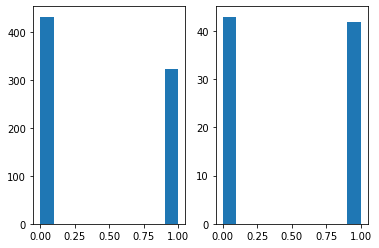

In [31]:
fig, ax = plt.subplots(1,2)
ax[0].hist(y_files_train);
ax[1].hist(y_files_val);

In [32]:
class LIDCGAN_3D(Dataset):
    def __init__(self, files_train_test, labels, transform = False):
        self.A = [f'{path_source}original/{i}.raw' for i in files_train_test]
        self.B = [f"{path_source}inpainted inserted/{i}.raw" for i in files_train_test]
        self.mask = [f"{path_source}mask/{i}.raw" for i in files_train_test]
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.A)
    
    def normalizePatches(self, npzarray):
        maxHU = 400.
        minHU = -1000.

        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def rotate_and_flip(self, image1, image2, image3):
        rand_int = np.random.randint(1,4)
        if np.random.rand() > .3:
            image1 = np.rot90(image1,rand_int).copy()
            image2 = np.rot90(image2,rand_int).copy()
            image3 = np.rot90(image3,rand_int).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,0).copy()
            image2 = np.flip(image2,0).copy()
            image3 = np.flip(image3,0).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,1).copy()
            image2 = np.flip(image2,1).copy()
            image3 = np.flip(image3,1).copy()
        return image1, image2, image3
    
    def rotate_3D(self, img):
        #Rotations
        rot_rand = np.random.randint(0,4)
        img = np.rot90(img, rot_rand, (0,1)).copy()
        rot_rand2 = np.random.randint(0,4)
        img = np.rot90(img, rot_rand2, (0,2)).copy()
        rot_rand3 = np.random.randint(0,4)
        img = np.rot90(img, rot_rand3, (1,2)).copy()
        #Flips
        if np.random.rand() > .5:
            img = np.flip(img, 1).copy()
        if np.random.rand() > .5:
            img = np.flip(img, 2).copy()
        if np.random.rand() > .5:
            img = np.flip(img, (1,2)).copy()
        return img
    
    def eulerAnglesToRotationMatrix(self, theta):
        thetaRad = np.zeros_like(theta)
        for ii in range(len(theta)):
            thetaRad[ii] = (theta[ii] / 180.) * np.pi     
        R_x = np.array([[1,         0,                  0                   ],
                        [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                        [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                        ])
        R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                        [0,                     1,      0                   ],
                        [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                        ])                 
        R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                        [math.sin(theta[2]),    math.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])                     
        R = np.dot(R_z, np.dot( R_y, R_x )) 
        return R
    
    def random_rotation_scaling(self, vol):
        # random rotation and scaling
        scaleFact = 0.5*np.random.rand() + 0.75
        rotFactX = 60.*np.random.rand() - 30
        rotFactY = 60.*np.random.rand() - 30
        rotFactZ = 60.*np.random.rand() - 30

        image_center = tuple(np.array(vol.shape) / 2 - 0.5)

        rotMat = self.eulerAnglesToRotationMatrix((rotFactX,rotFactY,rotFactZ))

        scaleMat = np.eye(3,3)
        scaleMat[0,0] *= scaleFact
        scaleMat[1,1] *= scaleFact
        scaleMat[2,2] *= scaleFact

        affMat = np.dot(rotMat,scaleMat)

        affine = sitk.AffineTransform(3)
        affine.SetMatrix(affMat.ravel())
        affine.SetCenter(image_center)

        img = sitk.GetImageFromArray(vol)
        refImg = img
        imgNew = sitk.Resample(img, refImg, affine,sitk.sitkLinear,0)

        vol = sitk.GetArrayFromImage(imgNew).copy()
        return vol
                              
        
    def random_crop(self, image):
        FINAL_SIZE=32
        remove = np.shape(image)[0] - FINAL_SIZE
        crop_Z = np.random.randint(8,24)
        crop_Y = np.random.randint(8,24)
        crop_X = np.random.randint(8,24)
        crop_Z_other_side = int(remove - crop_Z)
        crop_Y_other_side = int(remove - crop_Y)
        crop_X_other_side = int(remove - crop_X)
        crop_Y_random = np.random.rand() > .5
        crop_Z_random = np.random.rand() > .5
        crop_X_random = np.random.rand() > .5
        if crop_Y_random:
            image = image[:,crop_Y:-crop_Y_other_side,:]
        else:
            image = image[:,crop_Y_other_side:-crop_Y,:]
        if crop_Z_random:
            image = image[crop_Z:-crop_Z_other_side,:,:]
        else:
            image = image[crop_Z_other_side:-crop_Z,:,:]
        if crop_X_random:
            image = image[:,:,crop_X:-crop_X_other_side]
        else:
            image = image[:,:,crop_X_other_side:-crop_X]
        return image
    
    def __getitem__(self, idx):
        imgA = np.fromfile(self.A[idx],dtype='int16').astype('float32').reshape((64,64,64))
        imgB = np.fromfile(self.B[idx],dtype='int16').astype('float32').reshape((64,64,64))
        mask = np.fromfile(self.mask[idx],dtype='int16').astype('float32').reshape((64,64,64))
        label = self.labels[idx]
        
        
        # Rotations
        if self.transform: # == 'WARNING DO NOT DO ROTATIONS':
            imgA = self.random_rotation_scaling(imgA)
            mask = self.random_rotation_scaling(mask)
        
        if self.transform == 'WARNING DO NOT DO SHIFTS':
            imgA = self.random_crop(imgA)
            mask = self.random_crop(mask)
        else:
            imgA = imgA[16:-16, 16:-16, 16:-16]
            imgB = imgB[16:-16, 16:-16, 16:-16]
            mask = mask[16:-16, 16:-16, 16:-16]

#         imgB = self.random_crop(imgB)
#         mask = self.random_crop(mask)
        
        # normalize
        imgA = self.normalizePatches(imgA)
        imgB = self.normalizePatches(imgB) 
        
#         # Flips
#         if self.transform: # == 'WARNING DO NOT DO ROTATIONS':
#             imgA = self.rotate_3D(imgA)
#             mask = self.rotate_3D(mask)
                    
        # Add channels dimension
        imgA = np.expand_dims(imgA,0)
        imgB = np.expand_dims(imgB,0)
        mask = np.expand_dims(mask,0)
        label = np.expand_dims(label,0)
        
        # Pytorch
        imgA = Tensor(imgA)
        imgB = Tensor(imgB)
        mask = Tensor(mask)
        label = Tensor(label).long()
        label = label.squeeze()
                  
        # Get name to save the data                      
#         name = self.A[idx].split('orig/')[-1]
        name = self.A[idx]
    
        return imgA, label

In [33]:
slice_middle = 15
def plot_next_batch_dataloader(dataloader_iterX):
    a, labels = next(dataloader_iterX)
    for i, lab in zip(a, labels):
        lab = lab.detach().cpu().numpy()
        fig, ax = plt.subplots(1,figsize=(6,3))
        i = i[0].detach().cpu().numpy()
#         mm = mm[0].detach().cpu().numpy()
        ax.imshow(i[slice_middle], vmin=0, vmax=1)
        ax.set_title(f'{lab}')
#         ax[1].imshow(mm[slice_middle], vmin=0, vmax=1)
        fig.tight_layout()

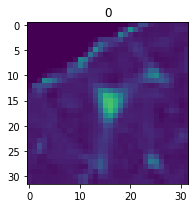

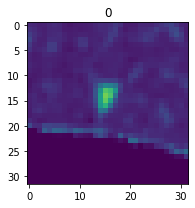

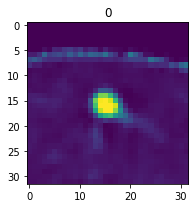

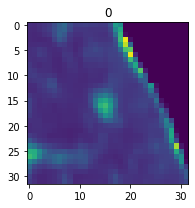

In [34]:
small_X_train = X_files_train[:8]
small_y_train = y_files_train[:8]

small_dataset_train = LIDCGAN_3D(small_X_train, small_y_train, transform=TRANSFORMS)
small_dataloader_train = DataLoader(small_dataset_train, batch_size=4)

small_dataloader_iter = iter(small_dataloader_train)
plot_next_batch_dataloader(small_dataloader_iter)

In [35]:
# small_dataset_train = LIDCGAN_3D(small_X_train, small_y_train, transform=False)
# dataloader_iter = iter(small_dataset_train)
# a, labels = next(dataloader_iter)
# a = a.detach().cpu().numpy()[0]

In [36]:
# b, aa= random_rotation_scaling(a)
# np.shape(b)
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(a[15])
# ax[1].imshow(b[15])

In [37]:
sampler = class_imbalance_sampler(y_files_train)

In [38]:
dataset_train = LIDCGAN_3D(X_files_train, y_files_train, transform=TRANSFORMS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCHSIZE, sampler = sampler)
dataset_val = LIDCGAN_3D(X_files_val, y_files_val, transform=False)
dataloader_val = DataLoader(dataset_val, batch_size=BATCHSIZE, shuffle=False)

In [39]:
# dataloader_iter_2D = iter(dataloader_train_2D)
# plot_next_batch_dataloader_2D(dataloader_iter_2D)

In [40]:
dataloader_iter = iter(dataloader_train)
for i in range(1):
    a, labels = next(dataloader_iter)
    if i==0:
        images_for_init = a
    else:
        images_for_init = torch.cat((images_for_init,a))
print(images_for_init.shape)
IMAGE_SIZE = images_for_init.shape[-1]

torch.Size([32, 1, 32, 32, 32])


In [41]:
# summary(model,(1,64,64))
# summary(model,(1,48,48))
summary(model,(1,32,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 32, 32, 32]             216
       BatchNorm3d-2        [-1, 8, 32, 32, 32]              16
         LeakyReLU-3        [-1, 8, 32, 32, 32]               0
         Dropout3d-4        [-1, 8, 32, 32, 32]               0
            Conv3d-5       [-1, 16, 16, 16, 16]           3,456
       BatchNorm3d-6       [-1, 16, 16, 16, 16]              32
         LeakyReLU-7       [-1, 16, 16, 16, 16]               0
         Dropout3d-8       [-1, 16, 16, 16, 16]               0
            Conv3d-9        [-1, 8, 16, 16, 16]             128
      BatchNorm3d-10        [-1, 8, 16, 16, 16]              16
        LeakyReLU-11        [-1, 8, 16, 16, 16]               0
        Dropout3d-12        [-1, 8, 16, 16, 16]               0
           Conv3d-13       [-1, 16, 16, 16, 16]           3,456
      BatchNorm3d-14       [-1, 16, 16,

In [42]:
if torch.cuda.is_available():
    model.cuda()
    print(f'using {device}')

using cuda


In [43]:
# WEIGHTS INIT
str_init='init_none'
if apply_weights_init:
    model.apply(weights_init);
    str_init = 'init_weights' 

In [44]:
# NAME FOR LSUV
str_layers = str(layers)
model_LSUV = f'{backbone_name}{str_layers}_{QC_name}_CH={CHANNELS}_LSUV={str(apply_LSUV)[:1]}'
model_LSUV = model_LSUV.replace(', ','').replace('[','_').replace(']', '')
model_LSUV = f'{model_LSUV}_SZ={IMAGE_SIZE}'
print(model_LSUV)
# LSUV
path_LSUVinit = 'classifier/LSUVinit_models/'
if apply_LSUV:
    # check if there is a preinit model already saved
    preinit_models = os.listdir(path_LSUVinit)
    preinit_models = [i.split('.pt')[0] for i in preinit_models]
    if model_LSUV in preinit_models:
        print('loading model already preinit with LSUV')
        model.load_state_dict(torch.load(f'{path_LSUVinit}{model_LSUV}.pt'))
    else:
        model = LSUVinit3D(model, a)
        if torch.cuda.is_available():
            model.cuda()
        str_init = 'init_LSUV'
        torch.save(model.state_dict(), f'{path_LSUVinit}{model_LSUV}.pt')

Darknet3D_v5_NF1=8_222_QCnone_CH=64_LSUV=T_SZ=32
loading model already preinit with LSUV


In [45]:
# LR finder
if LR_finder:
    lr=1e-7
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = F.cross_entropy
    lr_finder = LRFinder(model, opt, criterion, device="cuda")
    lr_finder.range_test(dataloader_train, end_lr=100, num_iter=100)
    lr_finder.plot()
    LR, oLoss, _, _ = find_lr_get_lr(lr_finder.history['lr'], lr_finder.history['loss'])
    plt.semilogx(lr_finder.history['lr'][:-5],lr_finder.history['loss'][:-5])
    plt.scatter(lr_finder.history['lr'][oLoss], lr_finder.history['loss'][oLoss], c='#000000')
    opt = optim.Adam(model.parameters(), lr=LR)
else:
    LR = 0.003
    opt = optim.Adam(model.parameters(), lr=LR)
    criterion = F.cross_entropy
LR

0.003

In [46]:
# Weights for imbalanced classes
if weight_balance:
    weights = []
    for i in np.sort(np.unique(y_files_train)):
        weights.append(1/(np.sum(y_files_train == i ) / len(df)))
    weights = weights/(np.sum(weights))
    weights = Tensor(weights)
    print(weights)
    if torch.cuda.is_available():
        print('cuda')
        weights = weights.cuda();

tensor([0.4272, 0.5728])
cuda


In [47]:
# NAME
str_layers = str(layers)
model_name = f'{backbone_name}{str_layers}_{QC_name}_CH={CHANNELS}_TR={str(TRANSFORMS)[:1]}_LSUV={str(apply_LSUV)[:1]}'
model_name = model_name.replace(', ','').replace('[','_').replace(']', '')
model_name = f'{model_name}_SZ={IMAGE_SIZE}_LR={LR:.0E}_DP={dropout}_NO_TRANS'

In [48]:
model_name

'Darknet3D_v5_NF1=8_222_QCnone_CH=64_TR=T_LSUV=T_SZ=32_LR=3E-03_DP=0.5_NO_TRANS'

In [52]:
epochs = 100
best_loss_val = 10000

# start training or continue training
if 'val_loss' not in locals():
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

for epoch in tqdm_notebook(range(epochs), total = len(range(epochs)), desc=f'training fold = {fold}'):
    y_train_all, y_val_all = [], []
    pred_train_proba_all, pred_val_proba_all = [], []
    correct_train, correct_val = 0, 0
    total_train, total_val = 0, 0
    loss_train_epoch, loss_val_epoch = 0, 0
    
    model.train()
    for idx, (Xa_train, y_train) in enumerate(dataloader_train):
        
        start = time.time()
        if weight_balance:
            pred_train_proba, loss, batch_total, batch_correct, _ = loss_batch_weight(model, criterion, Xa_train, y_train, device, weights)
        else:
            pred_train_proba, loss, batch_total, batch_correct, _ = loss_batch(model, criterion, Xa_train, y_train, device)
        correct_train += batch_correct
        total_train += batch_total
        loss_train_epoch += loss.detach().cpu().numpy()
        y_train_all.extend(y_train.detach().cpu().numpy())
        pred_train_proba_all.extend(pred_train_proba)
        # Backprop
        opt.zero_grad()
        loss.backward()
        opt.step()
    accuracy_train = 100 * correct_train / total_train

    model.eval() 
    with torch.no_grad():
        for idx_val, (Xa_val, y_val) in enumerate(dataloader_val):
            pred_val_proba, loss_val_batch, batch_total_val, batch_correct_val, _ = loss_batch(model, criterion, Xa_val, y_val, device)

            loss_val_epoch += loss_val_batch.detach().cpu().numpy()
            total_val += batch_total_val   
            correct_val += batch_correct_val
            pred_val_proba_all.extend(pred_val_proba)
            y_val_all.extend(y_val.detach().cpu().numpy())
        accuracy_val = 100 * correct_val/ total_val

        # Save best model according to val set
        model_saved_name = f'classifier/CNN_models/{model_name}'
        if best_loss_val > loss_val_epoch and epoch >= 2:
            best_loss_val = loss_val_epoch
            best_val_acc = accuracy_val
            pred_val_proba_best = pred_val_proba_all
            y_val_best = y_val_all    
            y_train_best = y_train_all    
            pred_train_proba_best = pred_train_proba_all
            torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict(),'optim_dict' : opt.state_dict()}, model_saved_name)
            
    train_loss.append(loss_train_epoch)
    val_loss.append(loss_val_epoch)
    train_accuracy.append(accuracy_train)
    val_accuracy.append(accuracy_val)

In [50]:
model_name

'Darknet3D_v5_NF1=8_222_QCnone_CH=64_TR=T_LSUV=T_SZ=32_LR=3E-03_DP=0.5_NO_TRANS'

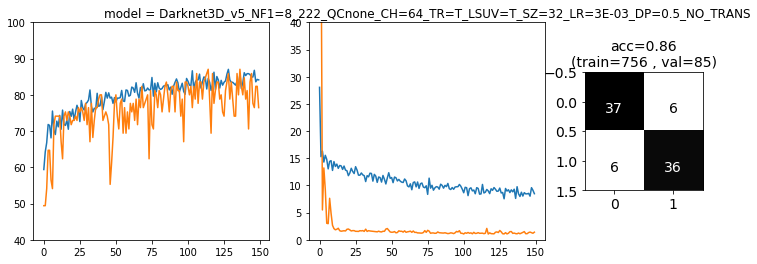

In [51]:
pred_val_class_best = [float(i>.5) for i in pred_val_proba_best]
accuracy_final = accuracy_score(y_val_best, pred_val_class_best)
cm = confusion_matrix(y_val_best, pred_val_class_best)

fig, ax = plt.subplots(1,3,figsize = (12,4), gridspec_kw = {'width_ratios':[4, 4, 2]})
ax[0].plot(train_accuracy)
ax[0].plot(val_accuracy)
# ax[0].set_title(f'LSUV = {apply_LSUV}         ')
ax[0].set_ylim([40,100])
ax[1].plot(train_loss)
ax[1].plot(val_loss)
ax[1].set_ylim([0,40])
ax[1].set_title(f'model = {model_name}')

classes = [int(i) for i in np.unique(y_val_best)]
thresh = cm.max() / 1.3
ax[2].imshow(cm, interpolation='nearest', cmap=plt.cm.Greys);
ax[2].set_title(f'acc={accuracy_final:.2f}\n(train={len(X_files_train)} , val={len(X_files_val)})', fontsize = 14)
plt.sca(ax[2])
plt.xticks(fontsize = 14);
plt.yticks(fontsize = 14);
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=0);
# plt.yticks(tick_marks2, classes2, rotation=0);
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
             verticalalignment = 'top',
         color="white" if cm[i, j] > thresh else "black", fontsize = 14)

fig.savefig(f'classifier/results/{model_name}.jpg')

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import flashtorch
from flashtorch.saliency import Backprop

In [3]:
!which flashtorch

In [4]:
backprop = Backprop(model)

NameError: name 'model' is not defined

In [ ]:
target_class = 1
backprop.visualize(a, 1, guided=True)

In [ ]:
small_dataset_train = LIDCGAN_3D(small_X_train, small_y_train, transform=False)
dataloader_iter = iter(small_dataset_train)
a, labels = next(dataloader_iter)
# a = a.detach().cpu().numpy()[0]

In [ ]:
# b, aa= random_rotation_scaling(a)
# np.shape(b)
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(a[15])
# ax[1].imshow(b[15])

In [ ]:
a.squeeze_()

In [ ]:
a.shape

In [ ]:
aa = a.detach().cpu().numpy()

In [ ]:
model(a)

In [ ]:
aaa = Variable(a.cuda(device))

In [ ]:
model(aaa)

In [ ]:
aaa.shape